Adversarial Autoencoder

Kolesov Alexandr m05-004

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.distributions as distributions
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
BATCH_SIZE = 32
EPOCHS = 4
generative_lr = 1e-3
reg_lr = 5*1e-4
EPS = 1e-15

In [54]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='./data',train = True, download=True, transform= transform)
test_data = torchvision.datasets.MNIST(root='/data',train = False, download = True,transform = transforms)
train_loader = data.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle= True)
test_loader = data.DataLoader(dataset= test_data, batch_size= BATCH_SIZE, shuffle= False)

In [55]:
def plot_tensor(tensor): 
  plt.imshow(tensor, cmap='gray')
  plt.show()

In [56]:
tensor_of_batch = (iter(train_loader).next())[0]
tensor_of_batch.shape

torch.Size([32, 1, 28, 28])

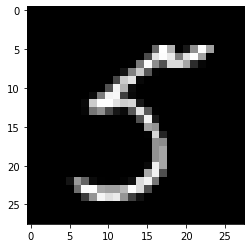

In [57]:
### consider one image
plot_tensor(tensor_of_batch[0][0])

In [58]:
# Encoder
class Q_net(nn.Module):
  
  def __init__(self,N,z_dim):
    super(Q_net,self).__init__()
    self.fc1 = nn.Linear(28*28,N)
    self.fc2 = nn.Linear(N,N)
    self.fc3 = nn.Linear(N,z_dim)
  def forward(self,x):

    x = x.view((-1,784)) # NOT torch.flatten(x), roll out the whole batch
    x = self.fc1(x)
    x = F.dropout(x , p=0.25, training = self.training)
    x = F.relu(x) # nn.ReLU()
    x = self.fc2(x)
    x = F.dropout(x , p=0.25, training = self.training)
    x = F.relu(x) # nn.ReLU()
    x = self.fc3(x)
    return  x

In [59]:
# Decoder
class P_net(nn.Module):

  def __init__(self,N,z_dim):
    super(P_net,self).__init__()
    self.fc1 = nn.Linear(z_dim,N)
    self.fc2 = nn.Linear(N,N)
    self.fc3 = nn.Linear(N,28*28)

  def forward(self,z):
    z = z.view((-1,120))
    x = self.fc1(z)
    x = F.dropout(x, p=0.25, training= self.training)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.dropout(x, p=0.25,training = self.training)
    x = F.relu(x)
    x = self.fc3(x)
    return torch.sigmoid(x) # image should be in [0,1]

In [60]:
# Discriminator
class D_net_gauss(nn.Module):

  def __init__(self,N,z_dim):
    super(D_net_gauss,self).__init__()
    self.fc1 = nn.Linear(z_dim,N)
    self.fc2 = nn.Linear(N,N)
    self.fc3 = nn.Linear(N,1)

  def forward(self,z):
    z = z.view((-1,120))
    x = self.fc1(z)
    x = F.dropout(x,p=0.2, training = self.training)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.dropout(x,p=0.2,training = self.training)
    x = F.relu(x)
    x = self.fc3(x)
    return torch.sigmoid(x) # since it is a probability

In [61]:
z_dims = 120
N = 1000
Q = Q_net(N,z_dims) # encoder
P = P_net(N,z_dims) # decoder
D_gauss = D_net_gauss(500,z_dims) # discriminator

In [62]:
#encode/decode optimizers
optim_P = torch.optim.Adam(P.parameters(), lr = generative_lr)
optim_Q_enc = torch.optim.Adam(Q.parameters(),lr = generative_lr)
optim_Q_gen = torch.optim.Adam(Q.parameters(), lr= reg_lr)
optim_D = torch.optim.Adam(D_gauss.parameters(), lr = reg_lr)

In [63]:
import tqdm
from tqdm import tqdm_notebook

In [64]:
def train_model(train_loader, Q, P, D_gauss, num_epochs):

  rec_loss = []
  discr_loss = []
  gen_loss = []

  optim_P = torch.optim.Adam(P.parameters(), lr = generative_lr)
  optim_Q_enc = torch.optim.Adam(Q.parameters(),lr = generative_lr)
  optim_Q_gen = torch.optim.Adam(Q.parameters(), lr= reg_lr)
  optim_D = torch.optim.Adam(D_gauss.parameters(), lr = reg_lr)

  

  for epoch in range(num_epochs):
    Q.train()
    P.train()
    D_gauss.train()
 
    for data,_ in tqdm_notebook(train_loader):
      P.zero_grad()
      Q.zero_grad()
      D_gauss.zero_grad()

      # reconstruction loss
      z_sample = Q(data)
      x_sample = P(z_sample)

      # for Binary Cross Entropy data should be [batch,784]
      # but not [batch,1,28,28] 
      data_ = torch.tensor([])
      for each_vector in data:
        data_ = torch.cat([data_,each_vector[0].view(-1,784)])
      


      recon_loss = F.binary_cross_entropy( x_sample + EPS, data_ + EPS)
      # one can try anothe loss , for instance, MSELoss 
      rec_loss.append(recon_loss.item())

      recon_loss.backward()
      optim_P.step()
      optim_Q_enc.step()

      # discriminator
      Q.eval()
      # under the assumption, that z_real from standard zero-mean Gauss
      z_real_gauss = torch.randn(BATCH_SIZE,z_dims)
      D_real_gauss = D_gauss(z_real_gauss)

      z_fake_gauss = Q(data)
      D_fake_gauss = D_gauss(z_fake_gauss)


      D_loss = - torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))
      discr_loss.append(D_loss)
      D_loss.backward()
      optim_D.step()

      # generator
      Q.train()
      z_fake_gauss = Q(data)
      #(z_fake_gauss.shape) == torch.Size([batch,120])
      D_fake_gauss = D_gauss(z_fake_gauss)
      #(D_fake_gauss.shape) == torch.Size([batch,1])
      G_loss = - torch.mean(torch.log(D_fake_gauss + EPS))
      gen_loss.append(G_loss)
      G_loss.backward()
      optim_Q_gen.step()

  return rec_loss, discr_loss, gen_loss


In [65]:
rec_loss, discr_loss, gen_loss = train_model(train_loader, Q ,P, D_gauss,EPOCHS)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


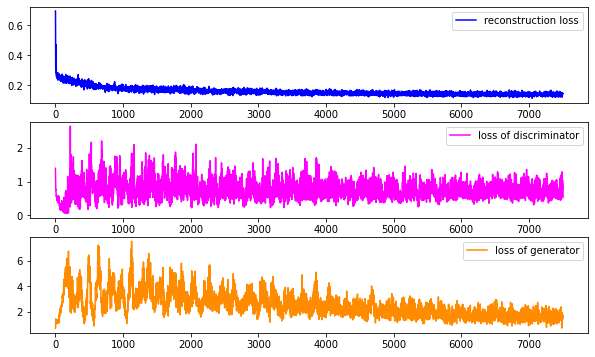

In [72]:
fig,ax = plt.subplots(3,1,figsize=(10,6))
ax[0].plot(rec_loss, color = 'blue', label = 'reconstruction loss')
ax[1].plot(discr_loss,color='magenta', label = 'loss of discriminator')
ax[2].plot(gen_loss,color='darkorange', label = 'loss of generator')
ax[1].legend()
ax[0].legend()
ax[2].legend()
plt.show()

One can how adversarial Autoencoder is able to reconstruct images from MNIST

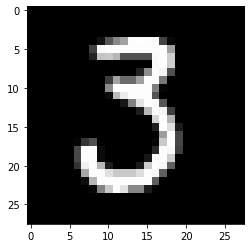

In [67]:
tensor_of_batch = (iter(train_loader).next())[0]
plot_tensor(tensor_of_batch[0][0])

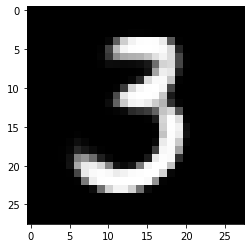

In [68]:
x = tensor_of_batch[0][0]
z = Q(x)
x = P(z)
x = x.reshape([28,28]).detach()
plot_tensor(x)

https://github.com/bfarzin/pytorch_aae/blob/master/main_aae.py

https://blog.paperspace.com/adversarial-autoencoders-with-pytorch/